In [38]:
import os
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
# from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from pprint import pprint

print("Number of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

Number of available GPUs:  0


The entire processed dataset is contained within `dataset.npz`, so load it.

In [39]:
data_dir = config['data_dir']

with np.load(os.path.join(data_dir, 'dataset_sample.npz')) as data:
    hsc_lenses = data['hsc_lens']
    hsc_nonlenses = data['hsc_nonlens']
    slsim_lenses = data['slsim_lens']
    slsim_nonlenses = data['slsim_nonlens']

print(f'hsc_lens: {hsc_lenses.shape}')
print(f'hsc_nonlens: {hsc_nonlenses.shape}')
print(f'slsim_lens: {slsim_lenses.shape}')
print(f'slsim_nonlens: {slsim_nonlenses.shape}')

hsc_lens: (2500, 41, 41, 5)
hsc_nonlens: (2500, 41, 41, 5)
slsim_lens: (2468, 41, 41, 5)
slsim_nonlens: (2500, 41, 41, 5)


Take a quick look at the four parts of the dataset: 
1. HSC Lenses
2. HSC Nonlenses
3. SLSim Lenses
4. SLSim Nonlenses

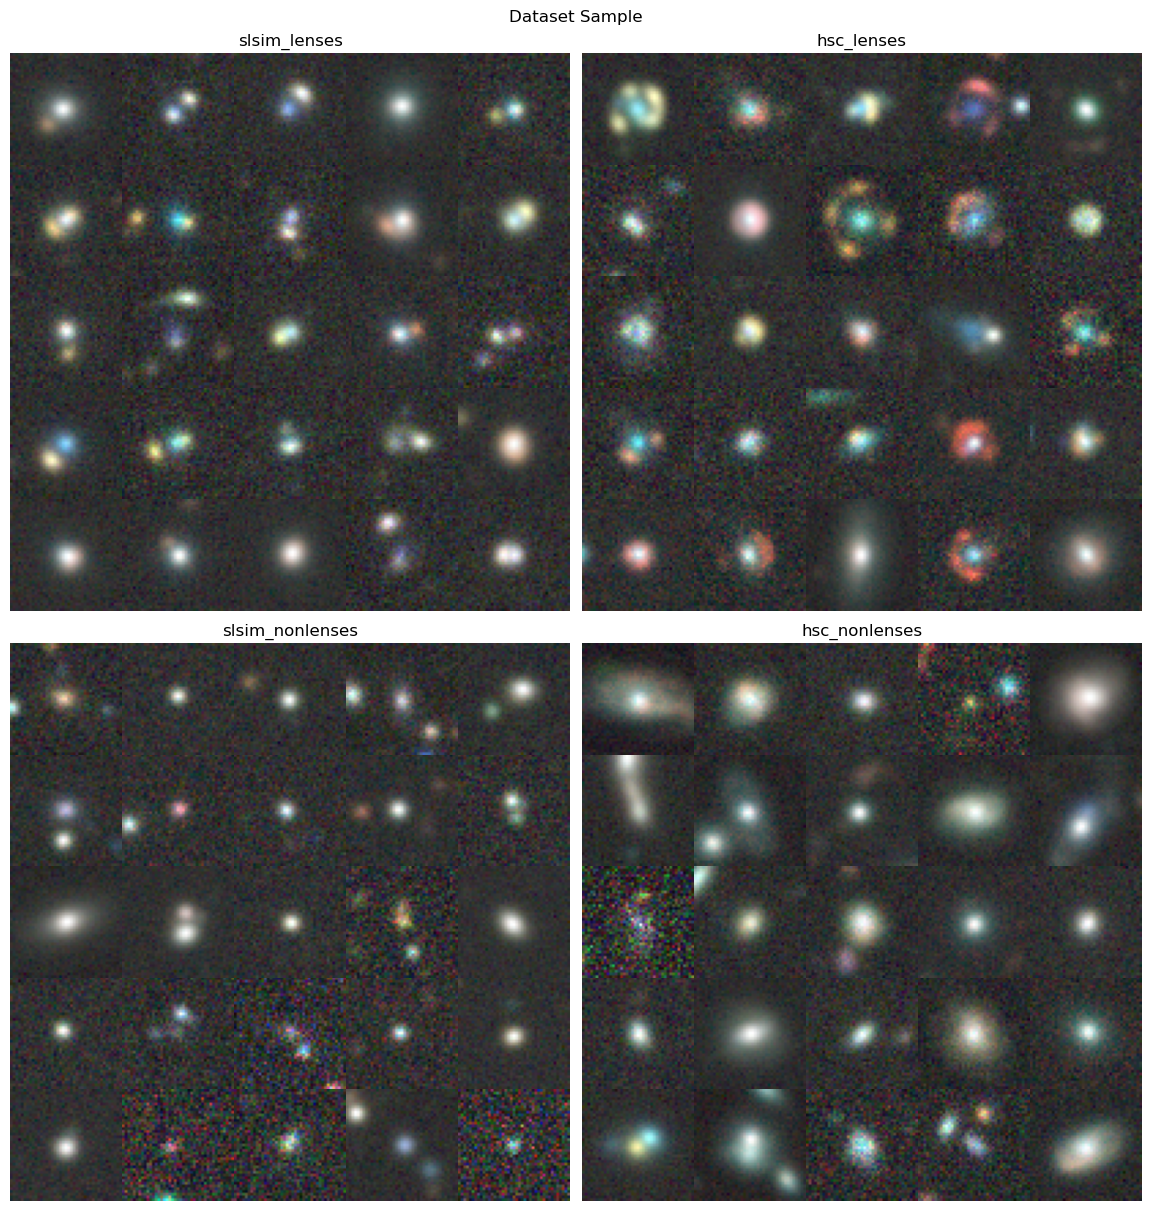

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(11.4, 12), constrained_layout=True)

datasets = [
    (slsim_lenses, "slsim_lenses"),
    (hsc_lenses, "hsc_lenses"),
    (slsim_nonlenses, "slsim_nonlenses"),
    (hsc_nonlenses, "hsc_nonlenses"),
]

for ax, (images, title) in zip(axes.flat, datasets):
    grid_size = min(25, len(images))
    grid_rows = grid_cols = int(np.ceil(np.sqrt(grid_size)))
    for i in range(grid_size):
        row = i // grid_cols
        col = i % grid_cols
        sub_ax = ax.inset_axes([col/grid_cols, 1-row/grid_rows-1/grid_rows, 1/grid_cols, 1/grid_rows])
        sub_ax.imshow(images[i][:,:,:3])
        sub_ax.axis("off")  # Hide axes for each image
    ax.set_title(title)
    ax.axis("off")  # Hide main axes

plt.suptitle('Dataset Sample')
plt.show()

Organize these four pieces into `data` and `labels` so that we can import it in a way that Tensorflow likes

In [41]:
data = np.concatenate([hsc_lenses, slsim_lenses, hsc_nonlenses, slsim_nonlenses], axis=0)
labels = np.array(([1] * (len(hsc_lenses) + len(slsim_lenses))) + ([0] * (len(hsc_nonlenses) + len(slsim_nonlenses))), dtype=np.uint8)
print(data.shape)
print(labels.shape)

(9968, 41, 41, 5)
(9968,)


Import the data and labels to a Tensorflow `Dataset`

In [42]:
ds = tf_data.Dataset.from_tensor_slices((data, labels))
ds = ds.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)

Split the whole dataset into a training, validation, and test set. The training and validation sets are used in the training process, and the test set is used to evaluate the model's performance against data it hasn't been trained on.

In [43]:
# Calculate split sizes
total_size = len(labels)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
print(f'end={total_size}, train={train_size}, val={val_size}, test={test_size}')

# Split the dataset
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

print(f"Train size: {train_ds.cardinality()}, Val size: {val_ds.cardinality()}, Test size: {test_ds.cardinality()}")

end=9968, train=6977, val=1993, test=998
Train size: 6977, Val size: 1993, Test size: 998


"Data augmentation" is a way of increasing the size of our training set, which makes the neural net perform better. Here, we're randomly flipping and rotating the images.

In [44]:
# data_augmentation_layers = [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
# ]

# def data_augmentation(images):
#     for layer in data_augmentation_layers:
#         images = layer(images)
#     return images

# # Apply `data_augmentation` to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf_data.AUTOTUNE,
# )

In [45]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.batch(256).prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.batch(256).prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.batch(256).prefetch(tf_data.AUTOTUNE)

Build the model

In [46]:
def make_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Entry block
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    outputs = layers.Dense(units, activation=None)(x)
    
    return models.Model(inputs, outputs)

In [47]:
# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     num_bands = input_shape[2]

#     # Entry block
#     x = layers.Conv2D(128, num_bands, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [256, 512, 728]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(num_bands, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, num_bands, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         units = 1
#     else:
#         units = num_classes

#     x = layers.Dropout(0.25)(x)
#     # We specify activation=None so as to return logits
#     outputs = layers.Dense(units, activation=None)(x)
#     return keras.Model(inputs, outputs)


# # model = make_model(input_shape=(41, 41, 5), num_classes=2)
# # keras.utils.plot_model(model, show_shapes=True)

Train the model

In [48]:
epochs = 100

# strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  # Or "/cpu:0" if no GPU  # MirroredStrategy()
# with strategy.scope():
model = make_model(input_shape=(41, 41, 5), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

callbacks = [
    early_stopping,
    # keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 541ms/step - acc: 0.6952 - loss: 0.6132 - val_acc: 0.4937 - val_loss: 0.8809
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 489ms/step - acc: 0.8937 - loss: 0.2384 - val_acc: 0.5083 - val_loss: 1.1286
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 491ms/step - acc: 0.9276 - loss: 0.1665 - val_acc: 0.5008 - val_loss: 1.3269
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 491ms/step - acc: 0.9478 - loss: 0.1332 - val_acc: 0.4802 - val_loss: 1.5302
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 491ms/step - acc: 0.9480 - loss: 0.1237 - val_acc: 0.5053 - val_loss: 0.9169
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 492ms/step - acc: 0.9678 - loss: 0.0894 - val_acc: 0.4787 - val_loss: 0.8443
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 494ms/step - acc: 0.9787 - loss: 0.0637 - val_acc: 0.5876 - val_loss: 0.6105
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 501ms/step - acc: 0.9746 - loss: 0.0611 - val_acc: 0.4977 - val_loss: 0.9084
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1

Plot the training and validation accuracy to sanity check that the training is going as expected. We can identify overfitting and underfitting by looking at this figure:
- Ideal Scenario: Training accuracy steadily increases and levels off at a high value. Validation accuracy follows closely and also levels off at a high value.
- Overfitting Scenario: Training accuracy keeps increasing and may reach 100%, but validation accuracy peaks early and then decreases.
- Underfitting Scenario: Both training and validation accuracy remain low.

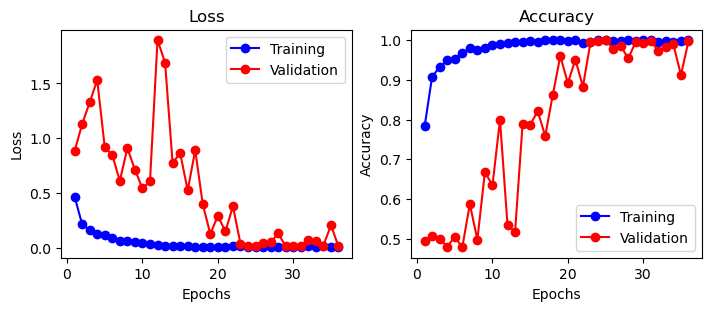

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

_, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
epoch_list = range(1, len(loss) + 1)

ax[0].plot(epoch_list, loss, 'bo-', label='Training')
ax[0].plot(epoch_list, val_loss, 'ro-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(epoch_list, accuracy, 'bo-', label='Training')
ax[1].plot(epoch_list, val_accuracy, 'ro-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
# ax[1].set_ylim(0, 1)
ax[1].legend()

plt.show()

In [50]:
score = model.evaluate(test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.014279698953032494
Test accuracy: 0.9929859638214111


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


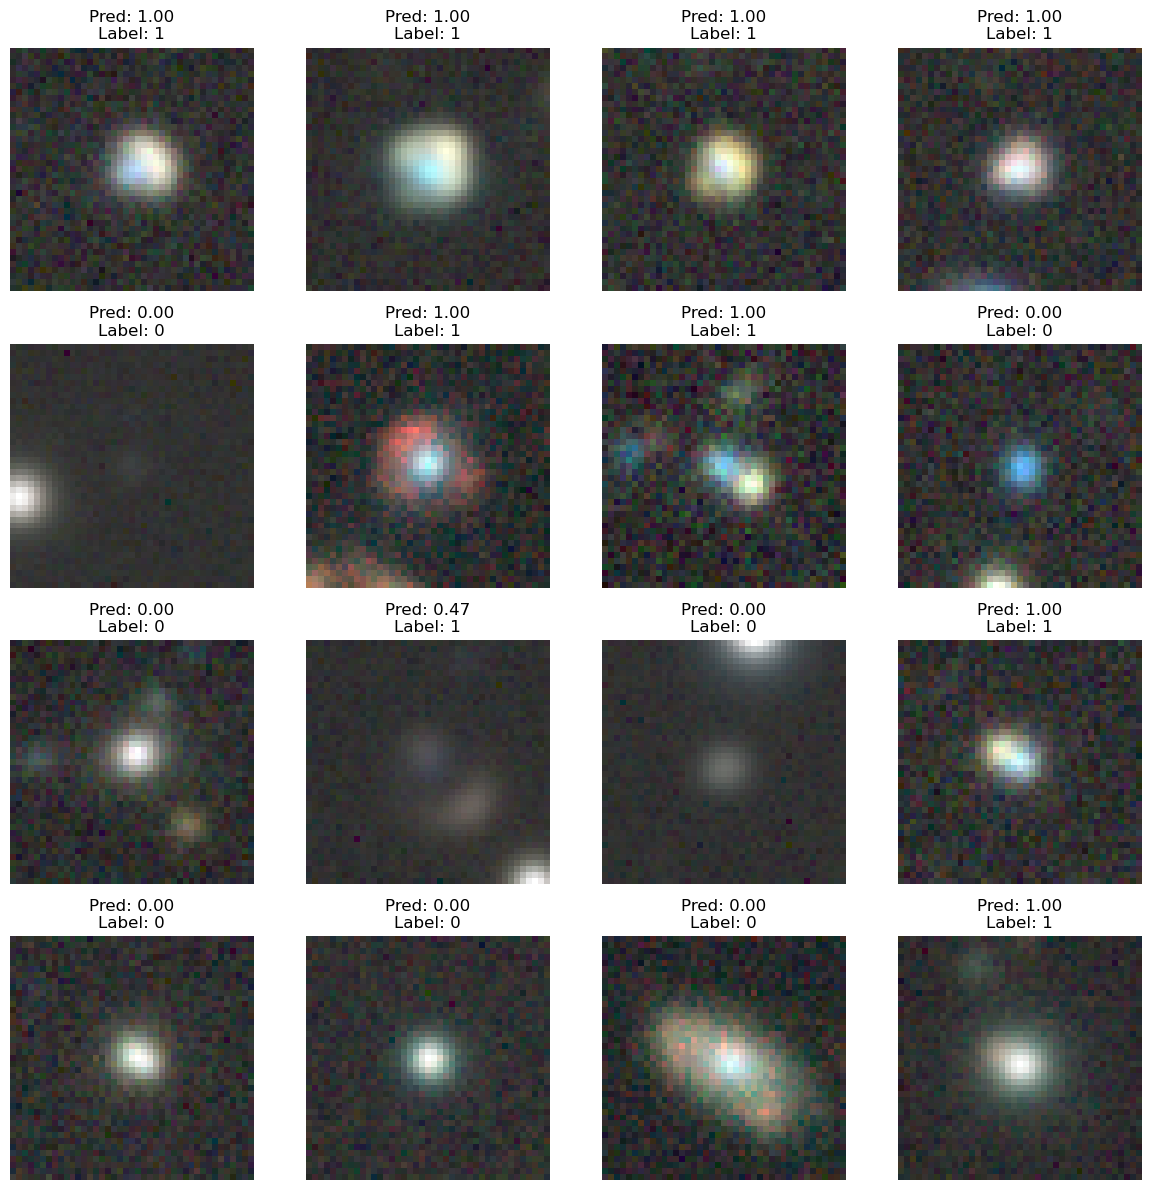

In [51]:
plt.figure(figsize=(12, 12))
for idx, (images_batch, labels_batch) in enumerate(test_ds.take(1)):
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    for i in range(min(16, images_batch.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy()[:,:,:3])
        plt.title(f"Pred: {probs[i]:.2f}\nLabel: {int(labels_batch[i])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

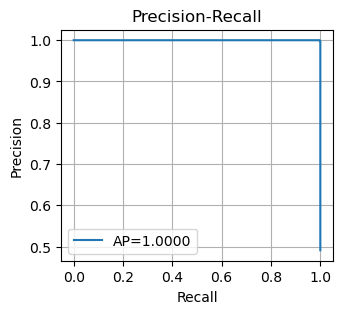

In [52]:
# Collect predictions and true labels from test_ds
y_true = []
y_scores = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch, verbose=0)
    probs = keras.ops.sigmoid(preds).numpy().flatten()  # Use sigmoid to get probabilities
    y_scores.extend(probs)
    y_true.extend(labels_batch.numpy().flatten())

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(3.5, 3))
plt.plot(recall, precision, label=f'AP={ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
model.save(f'/Users/jodie/lsst-strong-lens-data-challenge/bryce_copy_model_ap{str(round(ap_score, 8)).replace("0.","")}.keras')


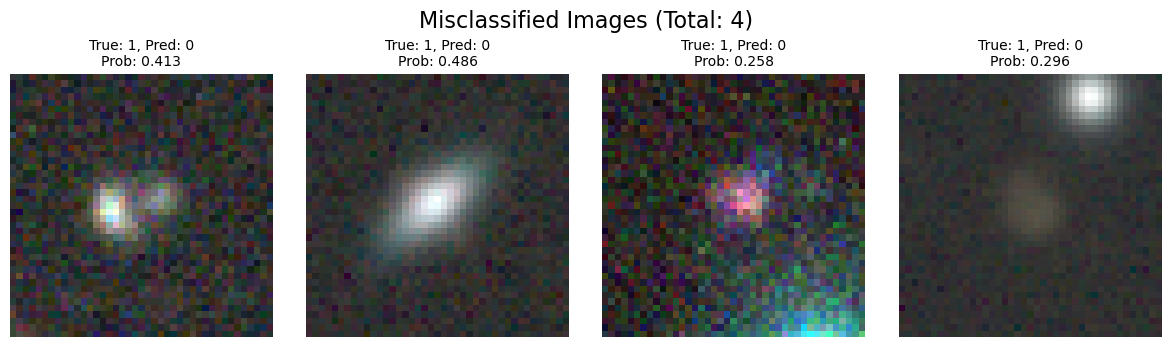

Total misclassified images: 4


In [54]:
# Collect misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_probs = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch, verbose=0)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    
    # Convert probabilities to binary predictions (threshold at 0.5)
    pred_labels = (probs > 0.5).astype(int)
    true_labels = labels_batch.numpy().flatten().astype(int)
    
    # Find misclassified samples
    misclassified_mask = pred_labels != true_labels
    
    if np.any(misclassified_mask):
        misclassified_images.extend(images_batch[misclassified_mask].numpy())
        misclassified_labels.extend(true_labels[misclassified_mask])
        misclassified_probs.extend(probs[misclassified_mask])

# Display misclassified images
num_to_show = min(16, len(misclassified_images))
if num_to_show > 0:
    plt.figure(figsize=(12, 12))
    for i in range(num_to_show):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(misclassified_images[i][:,:,:3])
        true_label = misclassified_labels[i]
        pred_prob = misclassified_probs[i]
        pred_label = 1 if pred_prob > 0.5 else 0
        plt.title(f"True: {true_label}, Pred: {pred_label}\nProb: {pred_prob:.3f}", fontsize=10)
        plt.axis("off")
    plt.suptitle(f"Misclassified Images (Total: {len(misclassified_images)})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Total misclassified images: {len(misclassified_images)}")
else:
    print("No misclassified images found!")